In [36]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [37]:
!pip list

Package                      Version
---------------------------- ---------------
absl-py                      2.1.0
aioice                       0.9.0
aiortc                       1.7.0
altair                       5.2.0
anyio                        4.2.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
audio-processing             0.0.1
av                           11.0.0
Babel                        2.14.0
beautifulsoup4               4.12.3
bleach                       6.1.0
blinker                      1.7.0
bs4                          0.0.2
build                        1.2.1
CacheControl                 0.14.0
cachetools                   5.3.2
caer                         2.0.8
canaro                       1.1.0
certifi                      2023.11.17
cffi                         1.

# Specify each path

In [38]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [39]:
NUM_CLASSES = 12

# Dataset reading

In [40]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [41]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [43]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [44]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 12)                132       
                                                                 
Total params: 1202 (4.70 KB)
Trainable params: 1202 (4.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [46]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [47]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[es_callback]
)

Epoch 1/1000
61/61 [==============================] - 1s 4ms/step - loss: 2.5893 - accuracy: 0.1074 - val_loss: 2.3605 - val_accuracy: 0.2258
Epoch 2/1000
61/61 [==============================] - 0s 2ms/step - loss: 2.3091 - accuracy: 0.2215 - val_loss: 2.0956 - val_accuracy: 0.3496
Epoch 3/1000
61/61 [==============================] - 0s 2ms/step - loss: 2.0547 - accuracy: 0.2999 - val_loss: 1.7925 - val_accuracy: 0.3943
Epoch 4/1000
61/61 [==============================] - 0s 2ms/step - loss: 1.8446 - accuracy: 0.3426 - val_loss: 1.5699 - val_accuracy: 0.4936
Epoch 5/1000
61/61 [==============================] - 0s 2ms/step - loss: 1.6832 - accuracy: 0.3784 - val_loss: 1.3871 - val_accuracy: 0.5790
Epoch 6/1000
61/61 [==============================] - 0s 2ms/step - loss: 1.5599 - accuracy: 0.4131 - val_loss: 1.2493 - val_accuracy: 0.6232
Epoch 7/1000
61/61 [==============================] - 0s 2ms/step - loss: 1.4577 - accuracy: 0.4365 - val_loss: 1.1353 - val_accuracy: 0.6411
Epoch 

In [48]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

21/21 [==============================] - 0s 900us/step - loss: 0.2607 - accuracy: 0.9589


In [49]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [50]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 42ms/step
[8.2752840e-06 5.7677003e-03 1.4351083e-03 3.2325145e-03 9.8208815e-01
 4.2559484e-05 4.7294228e-04 1.4954695e-05 8.5188652e-04 4.7576651e-03
 3.0401213e-09 1.3282584e-03]
4


# Confusion matrix

81/81 [==============================] - 0s 685us/step


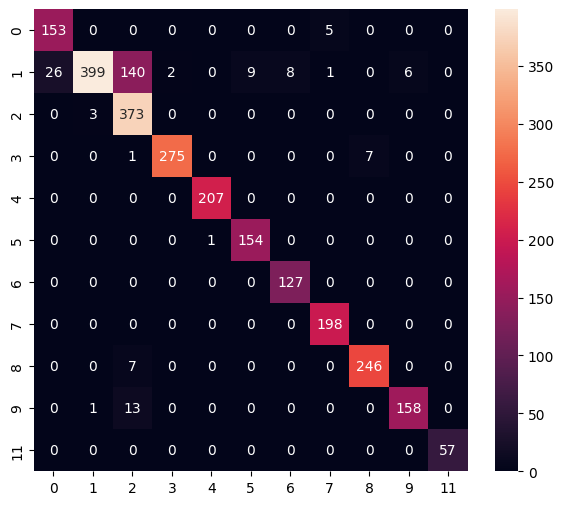

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       158
           1       0.99      0.68      0.80       591
           2       0.70      0.99      0.82       376
           3       0.99      0.97      0.98       283
           4       1.00      1.00      1.00       207
           5       0.94      0.99      0.97       155
           6       0.94      1.00      0.97       127
           7       0.97      1.00      0.99       198
           8       0.97      0.97      0.97       253
           9       0.96      0.92      0.94       172
          11       1.00      1.00      1.00        57

    accuracy                           0.91      2577
   macro avg       0.94      0.95      0.94      2577
weighted avg       0.93      0.91      0.91      2577



In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [52]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

c:\Python\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\K0NQ\AppData\Local\Temp\tmp2ee8i4cq\assets


INFO:tensorflow:Assets written to: C:\Users\K0NQ\AppData\Local\Temp\tmp2ee8i4cq\assets


6964

# Inference test

In [54]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [55]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [56]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [57]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [58]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.2752840e-06 5.7676970e-03 1.4351060e-03 3.2325131e-03 9.8208815e-01
 4.2559484e-05 4.7294228e-04 1.4954695e-05 8.5188565e-04 4.7576604e-03
 3.0401213e-09 1.3282590e-03]
4
